# Full waveform inversion in the frequency domain

## Forward model: the Helmholtz equation

In this notebook, we will implement a stylized forward model for ultrasound computed tomography (USCT) by use of the Helmholtz equation. The computational domain $\Omega$ is the unit circumference and the object consists of an inclusion with a higher speed of sound than the surrounding medium. 

Point-like sources will be assumed to be uniformely distributed along a circumference just outside the computational domain. The scattered pressure field $u(\boldsymbol{x})$ then solves the PDE

$$ -\Delta u - k^2 u = (k^2 - k_0^2) u_{inc} \text{ in } \Omega,$$
equipped with homogeneous Neumann boundary conditions
$$ \nabla u \cdot \boldsymbol{n} = 0 \text{ on } \partial\Omega.$$

Above $k$ is the spatially varying wave number and $k_0$ is the reference wave number associated with the incident wave $u_{inc}$.

Noisy values of the scattered pressure at the boundary of the computational domain will be measured, that is

$$ d(\boldsymbol{x}) = u(\boldsymbol{x}) + \text{noise}, \quad \forall \boldsymbol{x} \in \partial\Omega.$$



### Import dependencies

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import dolfin as dl
import ufl

from hippylib import nb

import numpy as np
import logging


logging.getLogger('FFC').setLevel(logging.WARNING)
logging.getLogger('UFL').setLevel(logging.WARNING)
dl.set_log_active(False)

np.random.seed(seed = 42)

### Define the computational domain, function spaces, and true parameter

The computational domain is the unit circle with center in the origin. A mesh with triangular elements is stored in `circle.xml`.

We use piecewise linear Lagrangian elements to discretize the parameter space (wave number perturbations) and piecewise quadratic elements to discretize the state space (scattered pressure field).

Refinement level 0; Number of mesh elements: 6402


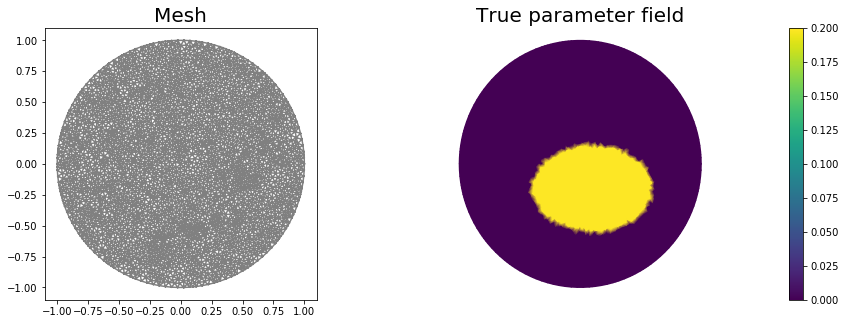

In [2]:
# create mesh and define function spaces
mesh = dl.Mesh("circle.xml")
print("Refinement level 0; Number of mesh elements: {0}".format(mesh.num_cells()))

nrefinements = 0
for i in range(nrefinements):
    mesh = dl.refine(mesh)
    print("Refinement level {0}; Number of mesh elements: {1}".format(i+1, mesh.num_cells()))
    

Vm = dl.FunctionSpace(mesh, 'Lagrange', 1)
Vu = dl.FunctionSpace(mesh, 'Lagrange', 2)

# The true parameter
mtrue_str = '.2*((x[0]-.1)*(x[0]-.1) + 2.*(x[1]+.2)*(x[1]+.2) < 0.25)'
mtrue = dl.interpolate(dl.Expression(mtrue_str, degree=5), Vm)

# plot
plt.figure(figsize=(15,5))
nb.plot(mesh, subplot_loc=121, mytitle="Mesh", show_axis='on')
nb.plot(mtrue, subplot_loc=122, mytitle="True parameter field")
plt.show()

## Define the reference wave number and the incident wave

Here we assume idealized point-like transducers.
For the case of an acoustic homogeneuous medium with speed of sound `c_0`, the acoustic wave generated by a point-like source with frequency $f$ can be analytically expressed as

$$ u_{i}(\boldsymbol{x}) = - \frac{ \cos( k_0 | \boldsymbol{x} - \boldsymbol{x}_i | )}{4 \pi | \boldsymbol{x} - \boldsymbol{x}_i | },$$

where $\boldsymbol{x}_i$ corresponds to the location of the point-like source and 

$$ k_0 = \frac{2 \pi f}{c_0} $$

is the reference wave number.

In what follow we consider the case of `nsources=3` point-like sources evenly distributed along a circunference of radius `radius=1.05`. The reference wave number is `k0 = 5`. 

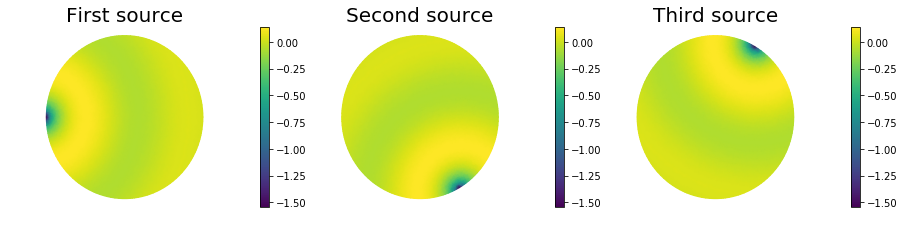

In [3]:
# initialize input functions
k0 = 5.
k0squared = dl.Constant(k0*k0)

nsources = 3
theta_view = np.linspace(-np.pi, np.pi, nsources, endpoint=False)
radius = 1.05
s0 = radius*np.cos(theta_view)
s1 = radius*np.sin(theta_view)

u_is = []

for i in np.arange(nsources):
    distance_source = dl.Expression("std::sqrt((x[0]-s0)*(x[0]-s0) + (x[1]-s1)*(x[1]-s1) )",
                                    s0 = s0[i], s1 = s1[i], degree=1)
    u_i_exp = dl.Expression("-std::cos(k0*distance_source)/(4.*DOLFIN_PI*distance_source)",
                              k0=k0, distance_source=distance_source, degree=6)
    u_is.append(dl.interpolate(u_i_exp, Vu) )
    
# plot
plt.figure(figsize=(15,3.3))
nb.plot(u_is[0], subplot_loc=131, mytitle="First source")
nb.plot(u_is[1], subplot_loc=132, mytitle="Second source")
nb.plot(u_is[2], subplot_loc=133, mytitle="Third source")
plt.show()

## Source encoding

Source encoding is a common technique based on superposition of effects to reduce the computational cost of full-waveform inversion.

Simply put, source encoding exploits the linearity of the Helmholtz equation with respect to the source term and computes a single pressure field correspoding to the simulataneous exitation of all sources together. Here, we take the superimposed source $u_inc$ to be a random linear combination of all sources $u_i$. The weights $e_i$ of this linear combination are sampled from a i.i.d. Gaussian distribution. That is:

$$ u_{inc}(\boldsymbol{x}) = \sum_i e_i u_i(\boldsymbol{x}), \quad e_i \sim \mathcal{N}(0,1). $$

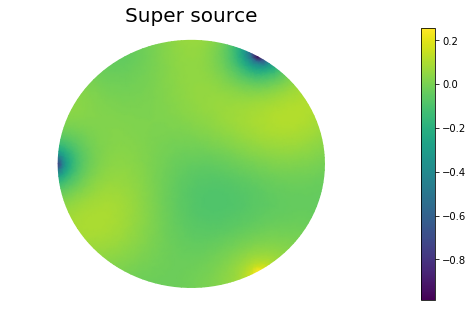

In [4]:
encoding   = np.random.normal(size=nsources)

u_inc = dl.Function(Vu)

for i, u_i in enumerate(u_is):
    u_inc.vector().axpy(encoding[i], u_i.vector())
    
plt.figure(figsize=(7.5,5))
nb.plot(u_inc, mytitle="Super source")
plt.show()

## The Helmholtz equation for the scattered field

The Helmohltz equation describes the wave generated by a source with frequency $f$ and propagating in an acoustic heterogeneous medium with speed of sound $c$. For the case of a point-like source, it reads

$$ -\Delta u_{tot} - k^2 u_{tot} = \sum_i e_i \delta_i(\boldsymbol{x}),$$

where $k = \frac{2\pi f}{c}$ is the (spacially varying) wave number, $\delta_i(\boldsymbol{x}) = \delta_i(\boldsymbol{x} - \boldsymbol{x}_i)$ is the Dirach delta corresponding to the point $\boldsymbol{x}_i$, and $e_i$ is the (random) weight associated to the $i$-th source.

Next we let $\xi = 1 - \frac{k^2}{k_0^2}$ be the spatially varing perturbation in the the wave number due by the acoustic heterogenity. By writing $u_{tot} = u + u_{inc}$, where $u$ is the scattered pressure and $u_{inc}$ is the incident pressure (i.e. the solution of the wave equation for the reference wave number $k_0$), we finally arrive to the following equation for the scattered pressure field

$$ -\Delta u - k_0^2(1 - \xi) u = - k_0^2 \xi u_{inc} \text{ in } \Omega.$$

For simplicity, homogeneous Neumann boundary conditions will be assumed on $\partial\Omega$, i.e.

$$ \nabla u \cdot \boldsymbol{n} = 0 \text{ on } \partial\Omega,$$

where $\boldsymbol{n}$ is the outward normal unit vector to $\partial\Omega$.

> Warning: In more realistic application, the so-called absorbing boundary conditions or a perfectly matched layer should be implemented to model wave propagation in infinite domains. However, this formulations require the use of a complex-valued pressure field u, which is not easy to implement in FEniCS.

Furthermore, to bound $\xi \in (0,1)$, we define the inversion parameter $m$, such that $\xi(m) = \tanh(m)$.



In [5]:
def pde_varf(u,m,p):
    return ufl.inner(ufl.grad(u), ufl.grad(p))*ufl.dx \
            -k0squared*(dl.Constant(1.) - ufl.tanh(m) )*u*p*ufl.dx \
            + k0squared*ufl.tanh(m)*u_inc*p*ufl.dx

bc_state = []


### Set up synthetic observations (inverse crime):

To generate the synthetic observation we first solve the PDE for the state variable ``utrue`` corresponding to the true parameter ``mtrue``. Here ``mtrue`` represents an oval inclusion with a $0.2$ difference from the background (see Cell 2).

Then we perturb the true state variable and write the observation ``d`` as

$$ d = u_{\rm true} + \eta, \quad {\rm where} \; \eta \sim \mathcal{N}(0, \sigma^2).$$

Here the standard variation $\sigma$ is proportional to ``noise_level``.

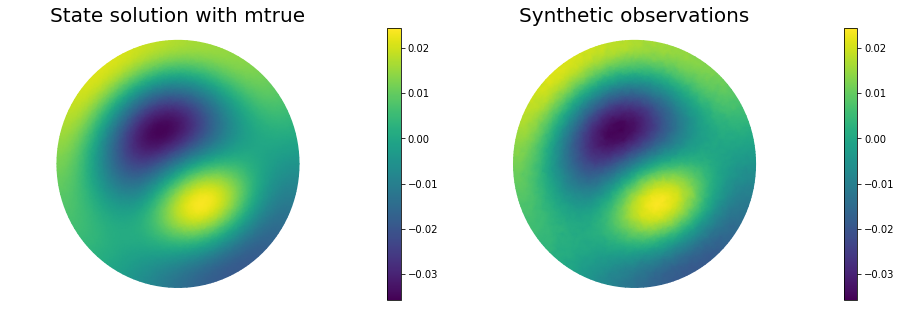

In [6]:
# noise level
noise_level = 0.01

u_trial = dl.TrialFunction(Vu)
u_test  = dl.TestFunction(Vu)

# weak form for setting up the synthetic observations
a_true = ufl.lhs(pde_varf(u_trial,mtrue,u_test))
L_true = ufl.rhs(pde_varf(u_trial,mtrue,u_test))

# solve the forward/state problem to generate synthetic observations
A_true, b_true = dl.assemble_system(a_true, L_true, bc_state)

utrue = dl.Function(Vu)
dl.solve(A_true, utrue.vector(), b_true)

d = dl.Function(Vu)
d.assign(utrue)

# perturb state solution and create synthetic measurements d
# d = u + ||u||/SNR * random.normal
MAX = d.vector().norm("linf")
noise = dl.Vector()
A_true.init_vector(noise,1)
noise.set_local( noise_level * MAX * np.random.normal(0, 1, len(d.vector().get_local())) )

d.vector().axpy(1., noise)

# plot
nb.multi1_plot([utrue, d], ["State solution with mtrue", "Synthetic observations"])
plt.show()

Copyright &copy; 2022, The University of Texas at Austin.

All Rights reserved. See file COPYRIGHT for details.

This file is part of `cvips_labs`, the teaching material for *Computational and Variational Methods for Inverse Problems* at The University of Texas at Austin. Please see https://hippylib.github.io/cvips_labs for more information and source code availability.

We would like to acknowledge the *Advanced Cyberinfrastructure Coordination Ecosystem: Services & Support* (ACCESS) program for providing cloud computing resources (Jetstream) for this course through allocation MTH230002. ACCESS is an advanced computing and data resource supported by the National Science Foundation and made possible through these lead institutions and their partners – Carnegie Mellon University; University of Colorado Boulder; University of Illinois at Urbana-Champaign; and State University of New York at Buffalo.